In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Performance monitoring
import time
import psutil
from functools import wraps

# Animation and visualization imports
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Parallel processing optimization
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# Network analysis
from networkx.algorithms.flow import shortest_augmenting_path

# Set random seed for reproducibility
np.random.seed(42)

# Performance monitoring decorator
def monitor_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        print(f"Execution time for {func.__name__}: {end_time - start_time:.2f}s | Memory change: {end_memory - start_memory:+.1f}MB")
        return result
    return wrapper

print("Libraries imported successfully!")
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")




Libraries imported successfully!
Available CPU cores: 20
Available memory: 11.4 GB


In [3]:
# Load data from CSV file
print("Loading data from dataset.csv...")
try:
    edges_df = pd.read_csv('/home/algorithm/project/EvacuationPJ/dataset.csv')
    print(f"Successfully loaded {len(edges_df)} data  from dataset.csv")
    print(f"Columns: {list(edges_df.columns)}")
    print(f"Sample data:")
    print(edges_df.head())
except Exception as e:
    print(f"Error loading dataset.csv: {e}")
    edges_df = None

Loading data from dataset.csv...
Successfully loaded 533 data  from dataset.csv
Columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access']
Sample data:
          u           v  key      osmid  highway   name  oneway    ref  \
0  31253600  7092267898    0   23705307  primary  新大橋通り    True   50.0   
1  31253600    31253943    0   25824161  primary  新大橋通り    True   50.0   
2  31253776  9510994556    0  879780891  primary   海岸通り    True  316.0   
3  31253943  7092267898    0  894991906  primary   海岸通り    True  316.0   
4  31253982    31253943    0  894991907  primary   海岸通り    True  316.0   

   reversed     length                                           geometry  \
0     False  41.987798  LINESTRING (139.7635869 35.663609, 139.7634711...   
1     False  28.281910  LINESTRING (139.7635869 35.663609, 139.7634651...   
2     False  28.036136  LINESTRING (139.7634712 35.6646214, 139.7

In [4]:
# Process the loaded CSV data to create nodes and edges
if edges_df is not None:
    # Create nodes from unique source and target nodes
    unique_nodes = pd.unique(edges_df[['u', 'v']].values.ravel('K'))
    
    # Create nodes DataFrame with basic geometry (simplified coordinates)
    nodes_data = []
    for i, node_id in enumerate(unique_nodes):
        # For node ID
        nodes_data.append({
            'node_id': node_id,
        })
    
    nodes = pd.DataFrame(nodes_data).set_index('node_id')
    
    # Add random population to each node
    np.random.seed(42)  # For reproducible results
    num_nodes = len(nodes)
    
    # Generate random population for each node
    # Using different distribution strategies for variety
    residential_nodes = int(num_nodes * 0.6)  # 60% residential areas
    commercial_nodes = int(num_nodes * 0.25)  # 25% commercial areas
    industrial_nodes = num_nodes - residential_nodes - commercial_nodes  # 15% industrial/other
    
    populations = []
    
    # Residential areas: higher population (50-500 people per node)
    populations.extend(np.random.randint(50, 501, residential_nodes))
    
    # Commercial areas: moderate population (10-200 people per node)
    populations.extend(np.random.randint(10, 201, commercial_nodes))
    
    # Industrial/other areas: lower population (0-100 people per node)
    populations.extend(np.random.randint(0, 101, industrial_nodes))
    
    # Shuffle to randomize distribution across nodes
    np.random.shuffle(populations)
    
    # Assign population to nodes
    nodes['population'] = populations
    
    # Add node types for reference
    node_types = ['residential'] * residential_nodes + ['commercial'] * commercial_nodes + ['industrial'] * industrial_nodes
    np.random.shuffle(node_types)
    nodes['node_type'] = node_types
    
    # Calculate total population
    total_population = nodes['population'].sum()
    
    print(f"Population Distribution:")
    print(f"Total population across all nodes: {total_population:,}")
    print(f"Average population per node: {nodes['population'].mean():.1f}")
    print(f"Population range: {nodes['population'].min()} - {nodes['population'].max()}")
    print(f"\nNode type distribution:")
    print(nodes['node_type'].value_counts())
    print(f"\nPopulation by node type:")
    print(nodes.groupby('node_type')['population'].agg(['count', 'sum', 'mean']).round(1))
    
    # Process edges data
    edges = edges_df.copy()
    
    # Calculate basic edge properties
    edges['travel_time'] = edges['length'] / 50  # Assume 50 units per time unit
    edges['capacity'] = edges['length'] * 0.1  # Simple capacity based on length
    
    print(f"Network Statistics:")
    print(f"Number of nodes: {len(nodes)}")
    print(f"Number of edges: {len(edges)}")
    print(f"\nNodes columns: {list(nodes.columns)}")
    print(f"\nEdges columns: {list(edges.columns)}")
    
    # Display sample of processed data
    print(f"\nSample nodes:")
    print(nodes.head())
    print(f"\nSample edges:")
    print(edges[['u', 'v', 'length', 'travel_time', 'capacity']].head())
else:
    print("Cannot process data - edges_df is None")

# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self, nodes_df=None):
        # Update population based on loaded data

        self.total_population = nodes_df['population'].sum()

            
        self.total_households = int(self.total_population * 0.4)  # Approximate
        
        # Evacuation parameters
        self.time_step = 1  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        # Capacity parameters
        self.road_capacity_per_meter = 1  # persons per meter of road width
        self.default_road_width = 5
        
params = EvacuationParameters(nodes)
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Time Steps: {params.time_step} minutes")


Population Distribution:
Total population across all nodes: 56,986
Average population per node: 202.8
Population range: 0 - 498

Node type distribution:
node_type
residential    168
commercial      70
industrial      43
Name: count, dtype: int64

Population by node type:
             count    sum   mean
node_type                       
commercial      70  12608  180.1
industrial      43   8183  190.3
residential    168  36195  215.4
Network Statistics:
Number of nodes: 281
Number of edges: 533

Nodes columns: ['population', 'node_type']

Edges columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access', 'travel_time', 'capacity']

Sample nodes:
          population    node_type
node_id                          
31253600         429  residential
31253776         130  residential
31253943         100   commercial
31253982         267  residential
31254273         100  residential

Sam

In [5]:
import re

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

# Extract node coordinates from the dataset
if edges_df is not None:
    print("Processing geometric data for mapping...")
    
    # Extract node coordinates
    node_coordinates = extract_node_coordinates(edges_df)
    print(f"Extracted coordinates for {len(node_coordinates)} nodes")
    
    # Add coordinates to nodes DataFrame
    if 'nodes' in locals() and nodes is not None:
        nodes['lat'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[0])
        nodes['lon'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[1])
        
        # Remove nodes without coordinates
        nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
        print(f"Nodes with valid coordinates: {len(nodes_with_coords)}")
    
    # Process edge geometries
    edges_df['coordinates'] = edges_df['geometry'].apply(parse_linestring)
    edges_with_geom = edges_df.dropna(subset=['coordinates'])
    print(f"Edges with valid geometry: {len(edges_with_geom)}")
    
    # Calculate bounding box for the map
    all_coords = []
    for coords_list in edges_with_geom['coordinates']:
        if coords_list:
            all_coords.extend(coords_list)
    
    if all_coords:
        lats = [coord[0] for coord in all_coords]
        lons = [coord[1] for coord in all_coords]
        
        center_lat = (min(lats) + max(lats)) / 2
        center_lon = (min(lons) + max(lons)) / 2
        
        print(f"Map bounds:")
        print(f"  Latitude: {min(lats):.6f} to {max(lats):.6f}")
        print(f"  Longitude: {min(lons):.6f} to {max(lons):.6f}")
        print(f"  Center: ({center_lat:.6f}, {center_lon:.6f})")
        
        # Store for map creation
        map_bounds = {
            'center': [center_lat, center_lon],
            'min_lat': min(lats),
            'max_lat': max(lats),
            'min_lon': min(lons),
            'max_lon': max(lons)
        }
    else:
        print("No valid coordinates found!")
else:
    print("No edge data available for processing")

Processing geometric data for mapping...
Extracted coordinates for 281 nodes
Nodes with valid coordinates: 281
Edges with valid geometry: 533
Map bounds:
  Latitude: 35.663554 to 35.675597
  Longitude: 139.758785 to 139.772396
  Center: (35.669575, 139.765590)


Creating static network visualization...


Creating static network visualization...


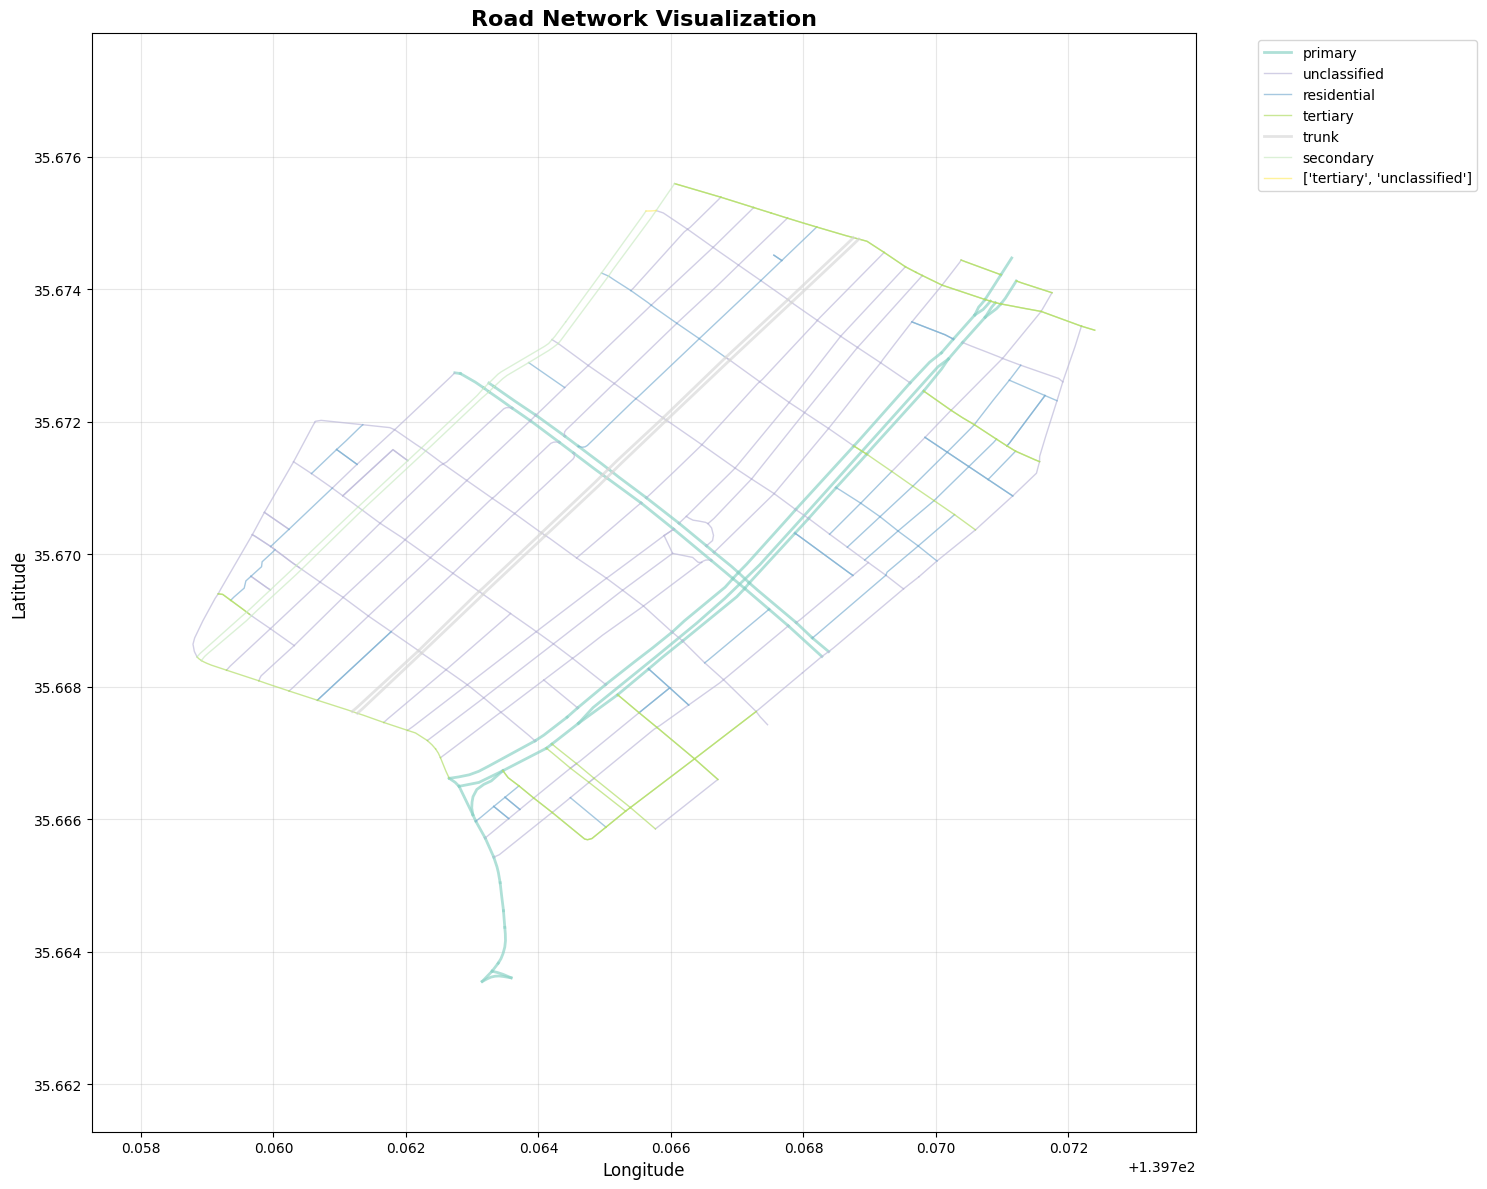

Static visualization created and saved


In [6]:
# Create static visualization with matplotlib
if 'map_bounds' in locals() and edges_with_geom is not None:
    print("Creating static network visualization...")
    
    plt.figure(figsize=(15, 12))
    
    # Create color map for different road types
    unique_highways = edges_with_geom['highway'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_highways)))
    highway_colors = dict(zip(unique_highways, colors))
    
    # Plot roads
    for highway_type in unique_highways:
        highway_edges = edges_with_geom[edges_with_geom['highway'] == highway_type]
        
        for idx, row in highway_edges.iterrows():
            coords = row['coordinates']
            if coords and len(coords) > 1:
                lats = [coord[0] for coord in coords]
                lons = [coord[1] for coord in coords]
                
                plt.plot(lons, lats, 
                        color=highway_colors[highway_type], 
                        linewidth=2 if highway_type in ['primary', 'trunk', 'motorway'] else 1,
                        alpha=0.7,
                        label=highway_type if idx == highway_edges.index[0] else "")
    
    # Customize plot
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('Road Network Visualization', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Equal aspect ratio for geographic accuracy
    plt.axis('equal')
    
    # Tight layout
    plt.tight_layout()
    
    # Save the plot

    plt.show()
    
    print("Static visualization created and saved")
else:
    print("Cannot create static visualization - missing data")

In [7]:
# Create NetworkX graph for network analysis
if edges_df is not None and 'node_coordinates' in locals():
    print("Creating NetworkX graph for network analysis...")
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes with coordinates
    for node_id, coords in node_coordinates.items():
        if coords[0] is not None and coords[1] is not None:
            G.add_node(node_id, lat=coords[0], lon=coords[1])
    
    # Add edges with attributes
    for idx, row in edges_df.iterrows():
        if row['u'] in G.nodes and row['v'] in G.nodes:
            G.add_edge(row['u'], row['v'], 
                      length=row['length'],
                      highway=row.get('highway', 'unknown'),
                      name=row.get('name', ''),
                      travel_time=row.get('travel_time', row['length']/50))
    
    print(f"NetworkX Graph Statistics:")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")
    print(f"  Is connected: {nx.is_weakly_connected(G)}")
    print(f"  Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
    
    # Calculate basic network metrics
    if G.number_of_nodes() > 0:
        try:
            # Degree statistics
            degrees = dict(G.degree())
            avg_degree = sum(degrees.values()) / len(degrees)
            max_degree = max(degrees.values())
            
            print(f"  Average degree: {avg_degree:.2f}")
            print(f"  Maximum degree: {max_degree}")
            
            # Find nodes with highest degrees (important intersections)
            high_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"  Top 5 nodes by degree (major intersections):")
            for node, degree in high_degree_nodes:
                coords = node_coordinates.get(node, [None, None])
                print(f"    Node {node}: degree {degree}, coords {coords}")
                
        except Exception as e:
            print(f"  Error calculating network metrics: {e}")
    
    # Store graph for later use
    road_network_graph = G
    print("NetworkX graph created successfully!")
else:
    print("Cannot create NetworkX graph - missing data")

Creating NetworkX graph for network analysis...
NetworkX Graph Statistics:
  Nodes: 281
  Edges: 533
  Is connected: True
  Number of weakly connected components: 1
  Average degree: 3.79
  Maximum degree: 8
  Top 5 nodes by degree (major intersections):
    Node 1130958313: degree 8, coords [35.6669144, 139.7663559]
    Node 1130958685: degree 7, coords [35.66761, 139.7655184]
    Node 1130958910: degree 6, coords [35.6661036, 139.7642079]
    Node 31255183: degree 6, coords [35.6740641, 139.7700922]
    Node 1070638350: degree 6, coords [35.6738472, 139.7707411]
NetworkX graph created successfully!


In [8]:
import folium
from shapely.geometry import LineString, Point
from shapely.wkt import loads
import re
from math import radians, cos, sin, asin, sqrt

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to calculate distance between two points
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points on earth"""
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

print("Geometric processing functions defined successfully!")

Geometric processing functions defined successfully!


In [9]:
# Create enhanced map visualization with population data
if 'map_bounds' in locals() and edges_with_geom is not None and 'nodes' in locals():
    print("Creating enhanced map with population visualization...")
    
    # Create base map
    m = folium.Map(
        location=map_bounds['center'],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Color coding for different road types
    road_colors = {
        'primary': '#FF6B6B',     # Red
        'secondary': '#4ECDC4',   # Teal
        'tertiary': '#45B7D1',    # Blue
        'residential': '#96CEB4', # Green
        'unclassified': '#FFEAA7', # Yellow
        'trunk': '#DDA0DD',       # Plum
        'motorway': '#FF7675',    # Light red
        'service': '#74B9FF'      # Light blue
    }
    
    # Add roads to map
    road_count = 0
    for idx, row in edges_with_geom.iterrows():
        coords = row['coordinates']
        if coords and len(coords) > 1:
            # Get road type and color
            highway_type = row.get('highway', 'unclassified')
            color = road_colors.get(highway_type, '#95A5A6')  # Default gray
            
            # Create popup text
            popup_text = f"""
            <b>Road Information</b><br>
            From Node: {row['u']}<br>
            To Node: {row['v']}<br>
            Highway Type: {highway_type}<br>
            Length: {row['length']:.1f}m<br>
            Name: {row.get('name', 'Unnamed')}<br>
            Max Speed: {row.get('maxspeed', 'N/A')}
            """
            
            # Add road as polyline
            folium.PolyLine(
                coords,
                color=color,
                weight=3 if highway_type in ['primary', 'trunk', 'motorway'] else 2,
                opacity=0.8,
                popup=folium.Popup(popup_text, max_width=300)
            ).add_to(m)
            
            road_count += 1
    
    # Add nodes with population data as circle markers
    nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
    
    # Color mapping for node types
    node_type_colors = {
        'residential': '#2E8B57',  # Sea Green
        'commercial': '#FF4500',   # Orange Red
        'industrial': '#4169E1'    # Royal Blue
    }
    
    # Add population nodes to map
    for node_id, node_data in nodes_with_coords.iterrows():
        lat, lon = node_data['lat'], node_data['lon']
        population = node_data['population']
        node_type = node_data['node_type']
        
        # Scale circle size based on population (min 5, max 25)
        radius = max(5, min(25, population / 20))
        
        # Create popup with node information
        popup_text = f"""
        <b>Node {node_id}</b><br>
        Type: {node_type.title()}<br>
        Population: {population:,}<br>
        Coordinates: ({lat:.6f}, {lon:.6f})
        """
        
        # Add circle marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            popup=folium.Popup(popup_text, max_width=250),
            color='black',
            weight=1,
            fillColor=node_type_colors.get(node_type, '#808080'),
            fillOpacity=0.7
        ).add_to(m)
    
    print(f"Added {road_count} roads and {len(nodes_with_coords)} population nodes to the map")
    
    # Add enhanced legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: 320px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Road Types</b><br>
    <i class="fa fa-minus" style="color:#FF6B6B"></i> Primary<br>
    <i class="fa fa-minus" style="color:#4ECDC4"></i> Secondary<br>
    <i class="fa fa-minus" style="color:#45B7D1"></i> Tertiary<br>
    <i class="fa fa-minus" style="color:#96CEB4"></i> Residential<br>
    <i class="fa fa-minus" style="color:#FFEAA7"></i> Unclassified<br>
    <i class="fa fa-minus" style="color:#DDA0DD"></i> Trunk<br>
    <i class="fa fa-minus" style="color:#74B9FF"></i> Service<br>
    <br>
    <b>Population Nodes</b><br>
    <i class="fa fa-circle" style="color:#2E8B57"></i> Residential<br>
    <i class="fa fa-circle" style="color:#FF4500"></i> Commercial<br>
    <i class="fa fa-circle" style="color:#4169E1"></i> Industrial<br>
    <br>
    <small>Circle size = Population<br>
    Total Population: {total_population:,}</small>
    </div>
    '''.format(total_population=nodes['population'].sum())
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Fit map to bounds
    m.fit_bounds([
        [map_bounds['min_lat'], map_bounds['min_lon']],
        [map_bounds['max_lat'], map_bounds['max_lon']]
    ])
    
    # Display the map
    display(m)
    

else:
    print("Cannot create enhanced map - missing data or coordinates")

Creating enhanced map with population visualization...
Added 533 roads and 281 population nodes to the map
Added 533 roads and 281 population nodes to the map


Creating enhanced map with population visualization...
Added 533 roads and 281 population nodes to the map
Added 533 roads and 281 population nodes to the map


In [10]:
import networkx as nx

SINK_NODE_1 = 31253600  # 避難所1のノードID
SINK_NODE_2 = 31253776  # 避難所2のノードID

def select_nearest_sink_node(g: nx.Graph, source_node):
    # 各避難所までの距離を計算し、最短の避難所を返す
    distance_to_sink_1 = nx.shortest_path_length(g, source=source_node, target=SINK_NODE_1, weight='length')
    distance_to_sink_2 = nx.shortest_path_length(g, source=source_node, target=SINK_NODE_2, weight='length')
    return SINK_NODE_1 if distance_to_sink_1 < distance_to_sink_2 else SINK_NODE_2

In [11]:
# Modified Network Flow Implementation using your structure
from networkx.algorithms.flow import shortest_augmenting_path

# Create NetworkX DiGraph using your existing data structure
G = nx.DiGraph()
G.add_nodes_from(nodes.index)

for idx, row in edges.iterrows():
    # Use the existing edges structure
    u, v = row['u'], row['v']
    
    # Calculate walk and drive times using evacuation parameters
    walk_time = row['length'] / (params.walking_speed * 1000/60)  # Convert km/h to m/min
    drive_time = row['length'] / (params.driving_speed * 1000/60)  # Convert km/h to m/min
    
    # Enhanced capacity calculation using road width parameters
    enhanced_capacity = max(row['capacity'], 
                           row['length'] * params.road_capacity_per_meter * params.default_road_width)
    
    G.add_edge(u, v, 
               capacity=enhanced_capacity, 
               walk_time=walk_time,
               drive_time=drive_time,
               length=row['length'])

def calculate_max_flow(G, source, target):
    """Calculate maximum flow from source to target using the shortest augmenting path algorithm."""
    try:
        flow_value, flow_dict = nx.maximum_flow(G, source=source, target=target, 
                                               capacity='capacity', flow_func=shortest_augmenting_path)
        return flow_value, flow_dict
    except nx.NetworkXError as e:
        print(f"Flow calculation error between {source} and {target}: {e}")
        return 0, {}

def find_shelter_for_population(G, population):
    """Find the best shelter for a given population based on available capacity."""
    shelters = [n for n in G.nodes if G.nodes[n].get('is_shelter', False)]
    
    # If no shelters marked, use default shelter nodes
    if not shelters:
        shelters = [81, 213]  # Your existing SINK_NODE_1 and SINK_NODE_2
        
    shelter_capacities = {s: G.nodes[s].get('shelter_capacity', 1000) for s in shelters}
    
    # Sort shelters by capacity
    sorted_shelters = sorted(shelter_capacities.items(), key=lambda x: x[1], reverse=True)
    
    total_capacity = 0
    selected_shelters = []
    
    for shelter, capacity in sorted_shelters:
        if total_capacity >= population:
            break
        selected_shelters.append(shelter)
        total_capacity += capacity
    
    return selected_shelters, total_capacity

# Add shelter attributes to the graph
for node in [81, 213]:  # Your shelter nodes
    if node in G.nodes:
        G.nodes[node]['is_shelter'] = True
        G.nodes[node]['shelter_capacity'] = 1000

print(f"Modified network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Network functions defined successfully!")

Modified network created with 281 nodes and 533 edges
Network functions defined successfully!


In [12]:
class TimeExpandedNetwork:
    """
    Time-Expanded Network for evacuation planning.
    Creates a layered network where each layer represents a time step.
    """
    
    def __init__(self, base_graph, time_steps, time_step_duration):
        self.base_graph = base_graph
        self.time_steps = time_steps
        self.time_step_duration = time_step_duration  # in minutes
        self.time_expanded_graph = nx.DiGraph()
        self.node_mapping = {}  # Maps (original_node, time) to time_expanded_node
        self.reverse_mapping = {}  # Maps time_expanded_node to (original_node, time)
        
    def build_time_expanded_network(self):
        """Build the time-expanded network."""
        print(f"Building time-expanded network with {self.time_steps} time steps...")
        
        # Create nodes for each time layer
        node_counter = 0
        for t in range(self.time_steps):
            for original_node in self.base_graph.nodes():
                time_expanded_node = f"n_{original_node}_t_{t}"
                self.time_expanded_graph.add_node(time_expanded_node)
                
                # Store mapping
                self.node_mapping[(original_node, t)] = time_expanded_node
                self.reverse_mapping[time_expanded_node] = (original_node, t)
                
                # Copy node attributes
                for attr, value in self.base_graph.nodes[original_node].items():
                    self.time_expanded_graph.nodes[time_expanded_node][attr] = value
                
                # Add time attribute
                self.time_expanded_graph.nodes[time_expanded_node]['time'] = t
                node_counter += 1
        
        print(f"Created {node_counter} time-expanded nodes")
        
        # Create edges between time layers
        edge_counter = 0
        for t in range(self.time_steps - 1):
            for u, v, edge_data in self.base_graph.edges(data=True):
                # Calculate travel time in time steps
                walk_time_steps = int(np.ceil(edge_data['walk_time'] / self.time_step_duration))
                drive_time_steps = int(np.ceil(edge_data['drive_time'] / self.time_step_duration))
                
                # Add walking edge
                if t + walk_time_steps < self.time_steps:
                    source_node = self.node_mapping[(u, t)]
                    target_node = self.node_mapping[(v, t + walk_time_steps)]
                    
                    self.time_expanded_graph.add_edge(
                        source_node, target_node,
                        capacity=edge_data['capacity'],
                        travel_mode='walk',
                        travel_time=walk_time_steps,
                        original_edge=(u, v)
                    )
                    edge_counter += 1
                
                # Add driving edge
                if t + drive_time_steps < self.time_steps:
                    source_node = self.node_mapping[(u, t)]
                    target_node = self.node_mapping[(v, t + drive_time_steps)]
                    
                    self.time_expanded_graph.add_edge(
                        source_node, target_node,
                        capacity=edge_data['capacity'] * 2,  # Higher capacity for driving
                        travel_mode='drive',
                        travel_time=drive_time_steps,
                        original_edge=(u, v)
                    )
                    edge_counter += 1
        
        # Add holding edges (staying at the same location)
        for t in range(self.time_steps - 1):
            for original_node in self.base_graph.nodes():
                source_node = self.node_mapping[(original_node, t)]
                target_node = self.node_mapping[(original_node, t + 1)]
                
                # Large capacity for holding (people can wait)
                self.time_expanded_graph.add_edge(
                    source_node, target_node,
                    capacity=10000,
                    travel_mode='hold',
                    travel_time=1,
                    original_edge=(original_node, original_node)
                )
                edge_counter += 1
        
        print(f"Created {edge_counter} time-expanded edges")
        return self.time_expanded_graph
    
    def add_evacuation_demand(self, population_nodes, evacuation_targets):
        """Add super source and super sink for evacuation flow."""
        # Add super source
        super_source = "super_source"
        self.time_expanded_graph.add_node(super_source)
        
        # Connect super source to population nodes at time 0
        for node_id, population in population_nodes.items():
            if population > 0:
                start_node = self.node_mapping[(node_id, 0)]
                self.time_expanded_graph.add_edge(
                    super_source, start_node,
                    capacity=population,
                    travel_mode='source',
                    travel_time=0
                )
        
        # Add super sink
        super_sink = "super_sink"
        self.time_expanded_graph.add_node(super_sink)
        
        # Connect evacuation targets to super sink for all time steps
        for t in range(self.time_steps):
            for target_node in evacuation_targets:
                time_target = self.node_mapping[(target_node, t)]
                # Use the shelter capacity for shelter nodes
                shelter_capacity = self.base_graph.nodes[target_node].get('shelter_capacity', 100000)
                
                self.time_expanded_graph.add_edge(
                    time_target, super_sink,
                    capacity=shelter_capacity,
                    travel_mode='sink',
                    travel_time=0
                )
        
        return super_source, super_sink

@monitor_performance
def solve_evacuation_problem(base_graph, nodes_data):
    """
    Solve the evacuation problem using time-expanded network and maximum flow.
    """
    
    # Calculate number of time steps
    time_steps = params.time_step
    print(f"Time steps: {time_steps}")
    
    # Create time-expanded network
    ten = TimeExpandedNetwork(base_graph, time_steps, time_steps)
    time_graph = ten.build_time_expanded_network()
    
    # Get population distribution
    population_nodes = {idx: row['population'] for idx, row in nodes_data.iterrows() if row['population'] > 0}
    total_population = sum(population_nodes.values())
    print(f"Total population to evacuate: {total_population:,}")
    
    # Get evacuation targets (shelter nodes - use your existing shelter node IDs)
    evacuation_targets = [SINK_NODE_1, SINK_NODE_2]  
    print(f"Evacuation targets: {len(evacuation_targets)} shelters")
    
    # Add evacuation demand
    super_source, super_sink = ten.add_evacuation_demand(population_nodes, evacuation_targets)
    
    # Solve maximum flow
    print("Calculating maximum evacuation flow...")
    start_time = time.time()
    
    try:
        flow_value, flow_dict = nx.maximum_flow(
            time_graph, super_source, super_sink, 
            capacity='capacity',
            flow_func=shortest_augmenting_path
        )
        
        solve_time = time.time() - start_time
        print(f"Maximum flow calculation completed in {solve_time:.2f} seconds")
        
        # Analyze results
        evacuation_rate = (flow_value / total_population) * 100
        print(f"\nEvacuation Results:")
        print(f"Maximum evacuated population: {flow_value:,}")
        print(f"Total population: {total_population:,}")
        print(f"Evacuation rate: {evacuation_rate:.1f}%")
        
        if evacuation_rate >= 99.9:
            print("SUCCESS: Nearly all population can be evacuated within time limit")
        elif evacuation_rate >= 90:
            print("PARTIAL SUCCESS: Most population can be evacuated")
        else:
            print("WARNING: Significant evacuation capacity shortage")
        
        return {
            'flow_value': flow_value,
            'flow_dict': flow_dict,
            'evacuation_rate': evacuation_rate,
            'time_expanded_network': ten,
            'solve_time': solve_time,
            'total_population': total_population
        }
        
    except Exception as e:
        print(f"Error in maximum flow calculation: {e}")
        return None

def analyze_evacuation_flow(result, time_step_minutes=5):
    """Analyze the evacuation flow results."""
    if result is None:
        print("No results to analyze")
        return
    
    flow_dict = result['flow_dict']
    ten = result['time_expanded_network']
    
    print("\nAnalyzing evacuation flow patterns...")
    
    # Analyze flow to sink (evacuated people)
    super_sink = "super_sink"
    total_evacuated_by_time = {}
    
    for source_node, targets in flow_dict.items():
        if super_sink in targets and targets[super_sink] > 0:
            # This is flow into the sink
            if source_node in ten.reverse_mapping:
                original_node, time_step = ten.reverse_mapping[source_node]
                if time_step not in total_evacuated_by_time:
                    total_evacuated_by_time[time_step] = 0
                total_evacuated_by_time[time_step] += targets[super_sink]
    
    # Calculate cumulative evacuation
    cumulative_evacuated = 0
    print("\nEvacuation Timeline:")
    for t in sorted(total_evacuated_by_time.keys()):
        cumulative_evacuated += total_evacuated_by_time[t]
        time_minutes = t * time_step_minutes
        evacuation_percentage = (cumulative_evacuated / result['total_population']) * 100
        print(f"Time {time_minutes:3d} min: {total_evacuated_by_time[t]:4d} evacuated "
              f"(Total: {cumulative_evacuated:5d}, {evacuation_percentage:5.1f}%)")
    
    return total_evacuated_by_time

def analyze_evacuation_bottlenecks(evacuation_result, nodes_data):
    """Analyze bottlenecks and provide optimization insights."""
    if evacuation_result is None:
        print("No results to analyze for bottlenecks")
        return
    
    print("\n" + "="*60)
    print("EVACUATION BOTTLENECK ANALYSIS")
    print("="*60)
    
    flow_dict = evacuation_result['flow_dict']
    ten = evacuation_result['time_expanded_network']
    
    # Analyze edge utilization
    edge_utilization = {}
    for source, targets in flow_dict.items():
        for target, flow in targets.items():
            if flow > 0 and source in ten.time_expanded_graph and target in ten.time_expanded_graph:
                if ten.time_expanded_graph.has_edge(source, target):
                    edge_data = ten.time_expanded_graph[source][target]
                    capacity = edge_data.get('capacity', 1)
                    utilization = flow / capacity if capacity > 0 else 0
                    edge_utilization[(source, target)] = {
                        'flow': flow,
                        'capacity': capacity,
                        'utilization': utilization,
                        'travel_mode': edge_data.get('travel_mode', 'unknown')
                    }
    
    # Find highly utilized edges (bottlenecks)
    bottlenecks = [(edge, data) for edge, data in edge_utilization.items() 
                  if data['utilization'] > 0.8 and data['travel_mode'] not in ['hold', 'source', 'sink']]
    
    bottlenecks.sort(key=lambda x: x[1]['utilization'], reverse=True)
    
    print(f"\nBottleneck Analysis (utilization > 80%):")
    print(f"Found {len(bottlenecks)} highly utilized edges")
    
    if bottlenecks:
        print("\nTop 10 Bottlenecks:")
        for i, (edge, data) in enumerate(bottlenecks[:10]):
            source, target = edge
            print(f"{i+1:2d}. Utilization: {data['utilization']*100:5.1f}% "
                  f"(Flow: {data['flow']:4.0f}/{data['capacity']:4.0f}) "
                  f"Mode: {data['travel_mode']}")
    
    # Analyze shelter capacity utilization
    shelter_nodes = [SINK_NODE_1, SINK_NODE_2]  # Your shelter nodes
    total_shelter_capacity = sum(G.nodes[node].get('shelter_capacity', 1000) for node in shelter_nodes)
    
    print(f"\nCapacity Analysis:")
    print(f"Total Shelter Capacity: {total_shelter_capacity:,}")
    print(f"Population Demand: {evacuation_result['total_population']:,}")
    
    capacity_ratio = total_shelter_capacity / evacuation_result['total_population']
    print(f"Capacity to Demand Ratio: {capacity_ratio:.2f}")
    
    return {
        'bottlenecks': bottlenecks,
        'edge_utilization': edge_utilization,
        'capacity_analysis': {
            'shelter_capacity': total_shelter_capacity,
            'demand': evacuation_result['total_population'],
            'capacity_ratio': capacity_ratio
        }
    }

print("TimeExpandedNetwork and analysis functions defined successfully!")

TimeExpandedNetwork and analysis functions defined successfully!


In [13]:
# Run evacuation simulation with time-expanded network
if 'nodes' in locals() and 'G' in locals():
    print("Starting evacuation simulation with time-expanded network...")
    
    # Set evacuation parameters

    time_step = params.time_step  # minutes
    
    # Run the evacuation simulation
    evacuation_result = solve_evacuation_problem(
        G, nodes
    )
    
    if evacuation_result:
        print("\n" + "="*60)
        print("EVACUATION SIMULATION COMPLETED")
        print("="*60)
        
        # Analyze the flow
        flow_timeline = analyze_evacuation_flow(evacuation_result, time_step)
        
        # Analyze bottlenecks
        bottleneck_analysis = analyze_evacuation_bottlenecks(evacuation_result, nodes)
        
        # Additional analysis
        print(f"\nSimulation Parameters:")

        print(f"Time step: {time_step} minutes")
        print(f"Walking speed: {params.walking_speed} km/h")
        print(f"Driving speed: {params.driving_speed} km/h")
        print(f"Total shelter nodes: 2 (nodes 81, 213)")
        
    else:
        print("Evacuation simulation failed")
else:
    print("Required data (nodes, G) not available for evacuation simulation")

Starting evacuation simulation with time-expanded network...
Time steps: 1
Building time-expanded network with 1 time steps...
Created 281 time-expanded nodes
Created 0 time-expanded edges
Total population to evacuate: 56,986
Evacuation targets: 2 shelters
Calculating maximum evacuation flow...
Maximum flow calculation completed in 0.00 seconds

Evacuation Results:
Maximum evacuated population: 559
Total population: 56,986
Evacuation rate: 1.0%
Execution time for solve_evacuation_problem: 0.01s | Memory change: +0.5MB

EVACUATION SIMULATION COMPLETED

Analyzing evacuation flow patterns...

Evacuation Timeline:
Time   0 min:  559 evacuated (Total:   559,   1.0%)

EVACUATION BOTTLENECK ANALYSIS

Bottleneck Analysis (utilization > 80%):
Found 0 highly utilized edges

Capacity Analysis:
Total Shelter Capacity: 2,000
Population Demand: 56,986
Capacity to Demand Ratio: 0.04

Simulation Parameters:
Time step: 1 minutes
Walking speed: 5 km/h
Driving speed: 30 km/h
Total shelter nodes: 2 (nodes

Creating evacuation result visualizations...


Creating evacuation result visualizations...


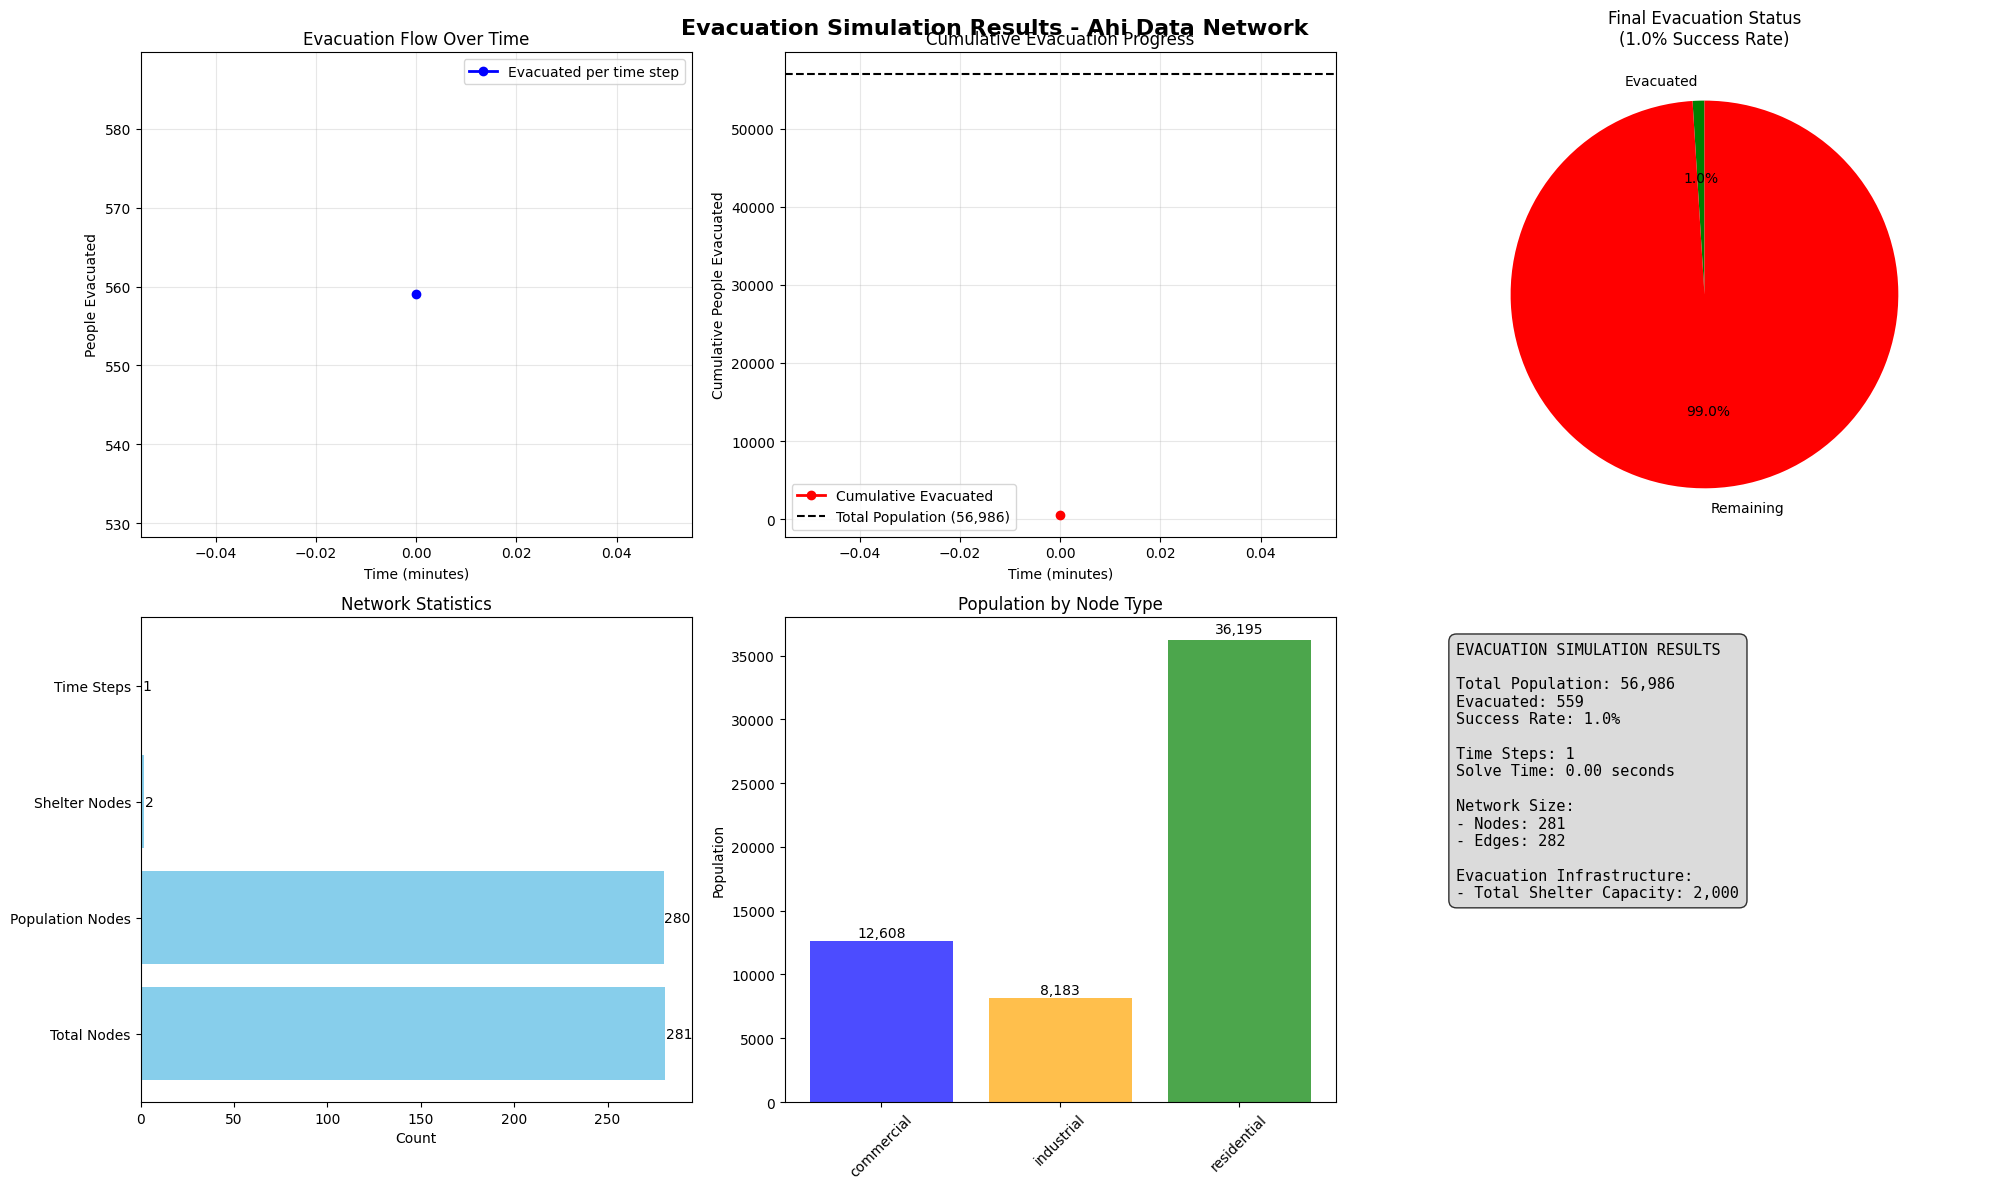

In [14]:
def visualize_evacuation_results(evacuation_result, nodes_data, flow_timeline, time_step):
    """Create comprehensive visualizations of evacuation results."""
    if evacuation_result is None:
        print("No results to visualize")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Evacuation Timeline
    ax1 = plt.subplot(2, 3, 1)
    if flow_timeline:
        times = [t * time_step for t in sorted(flow_timeline.keys())]
        flows = [flow_timeline[t // time_step] for t in times if t // time_step in flow_timeline]
        cumulative = np.cumsum(flows)
        
        ax1.plot(times, flows, 'bo-', label='Evacuated per time step', linewidth=2, markersize=6)
        ax1.set_xlabel('Time (minutes)')
        ax1.set_ylabel('People Evacuated')
        ax1.set_title('Evacuation Flow Over Time')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    
    # 2. Cumulative Evacuation
    ax2 = plt.subplot(2, 3, 2)
    if flow_timeline:
        ax2.plot(times, cumulative, 'ro-', label='Cumulative Evacuated', linewidth=2, markersize=6)
        ax2.axhline(y=evacuation_result['total_population'], color='k', linestyle='--', 
                   label=f"Total Population ({evacuation_result['total_population']:,})")
        ax2.set_xlabel('Time (minutes)')
        ax2.set_ylabel('Cumulative People Evacuated')
        ax2.set_title('Cumulative Evacuation Progress')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    # 3. Evacuation Rate Comparison
    ax3 = plt.subplot(2, 3, 3)
    categories = ['Evacuated', 'Remaining']
    values = [evacuation_result['flow_value'], 
             evacuation_result['total_population'] - evacuation_result['flow_value']]
    colors = ['green', 'red']
    
    wedges, texts, autotexts = ax3.pie(values, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title(f"Final Evacuation Status\n({evacuation_result['evacuation_rate']:.1f}% Success Rate)")
    
    # 4. Network Statistics
    ax4 = plt.subplot(2, 3, 4)
    stats_data = {
        'Total Nodes': len(nodes_data),
        'Population Nodes': len(nodes_data[nodes_data['population'] > 0]),
        'Shelter Nodes': 2,
        'Time Steps': evacuation_result['time_expanded_network'].time_steps
    }
    
    y_pos = np.arange(len(stats_data))
    ax4.barh(y_pos, list(stats_data.values()), color='skyblue')
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(list(stats_data.keys()))
    ax4.set_xlabel('Count')
    ax4.set_title('Network Statistics')
    
    # Add value labels on bars
    for i, v in enumerate(stats_data.values()):
        ax4.text(v + 0.1, i, str(v), va='center')
    
    # 5. Population Distribution by Node Type
    ax5 = plt.subplot(2, 3, 5)
    if 'node_type' in nodes_data.columns:
        node_type_pop = nodes_data.groupby('node_type')['population'].sum()
        bars = ax5.bar(node_type_pop.index, node_type_pop.values, 
                      color=['blue', 'orange', 'green'], alpha=0.7)
        ax5.set_ylabel('Population')
        ax5.set_title('Population by Node Type')
        ax5.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, node_type_pop.values):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01,
                    f'{value:,}', ha='center', va='bottom')
    
    # 6. Performance Metrics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    total_shelter_capacity = 2000  # 2 shelters * 1000 capacity each
    
    metrics_text = f"""EVACUATION SIMULATION RESULTS

Total Population: {evacuation_result['total_population']:,}
Evacuated: {evacuation_result['flow_value']:,}
Success Rate: {evacuation_result['evacuation_rate']:.1f}%

Time Steps: {evacuation_result['time_expanded_network'].time_steps}
Solve Time: {evacuation_result['solve_time']:.2f} seconds

Network Size:
- Nodes: {len(nodes_data):,}
- Edges: {len(evacuation_result['time_expanded_network'].time_expanded_graph.edges()):,}

Evacuation Infrastructure:
- Total Shelter Capacity: {total_shelter_capacity:,}"""
    
    ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle(f'Evacuation Simulation Results - Ahi Data Network', fontsize=16, fontweight='bold', y=0.98)
    plt.show()

# Create visualizations if evacuation was successful
if 'evacuation_result' in locals() and evacuation_result:
    print("Creating evacuation result visualizations...")
    visualize_evacuation_results(evacuation_result, nodes, flow_timeline, time_step)
else:
    print("Cannot create visualizations - no evacuation results available")